In [1]:
import numpy as np
import h5py 
from matplotlib import pyplot as plt
from MD_AE_model import *

2022-02-21 15:12:07.828705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-21 15:12:07.828724: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
folder = "/home/ym917/OneDrive/PhD/Code_md-ae/MD_2__2022_02_02__16_51_24/"

filename = folder + 'results.h5'
file = h5py.File(filename,'r')
u_train = np.array(file.get('u_train')) # fluctuating velocity if REMOVE_MEAN is true
y_train = np.array(file.get('y_train'))
u_test = np.array(file.get('u_test')) # fluctuating velocity if REMOVE_MEAN is true
y_test = np.array(file.get('y_test'))
u_avg = np.array(file.get('u_avg'))
latent_train = np.array(file.get('latent_train'))
latent_test = np.array(file.get('latent_test'))
modes_train = np.array(file.get('modes_train'))
modes_test = np.array(file.get('modes_test')) #(modes,snapshots,Nx,Ny,Nu)
file.close()

filename = folder + 'Model_param.h5'
file = h5py.File(filename,'r')
lmb = file.get('lmb')[()]#1e-05 #regulariser
drop_rate = file.get('drop_rate')[()]
features_layers = np.array(file.get('features_layers')).tolist()
latent_dim = file.get('latent_dim')[()]
act_fct = file.get('act_fct')[()].decode()
resize_meth = file.get('resize_meth')[()].decode()
filter_window= np.array(file.get('filter_window')).tolist()
batch_norm = file.get('batch_norm')[()]
REMOVE_MEAN = file.get('REMOVE_MEAN')[()]
file.close()

0.7067236301562139


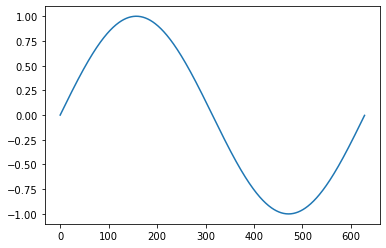

In [8]:
plt.plot(np.sin(np.r_[0:2*np.pi:0.01]))
print(np.mean(np.sin(np.r_[0:2*np.pi:0.01])**2,0)**0.5)

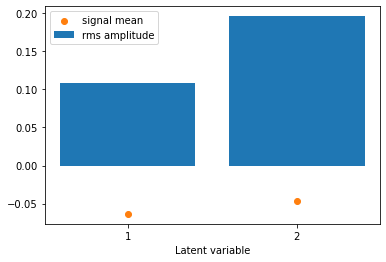

In [26]:
#========================= RMS amplitude of latent variable =====================
# amp_rms = np.mean(latent_test**2,0)**0.5
amp_rms = np.mean((latent_test-np.mean(latent_test,0))**2,0)**0.5 
plt.figure()
plt.bar(np.arange(latent_dim)+1,amp_rms,label='rms amplitude')
plt.scatter(np.arange(latent_dim)+1,np.mean(latent_test,0),label='signal mean')
plt.xticks(np.arange(latent_dim)+1)
plt.legend()
plt.xlabel("Mode")
plt.show()

<class 'list'>


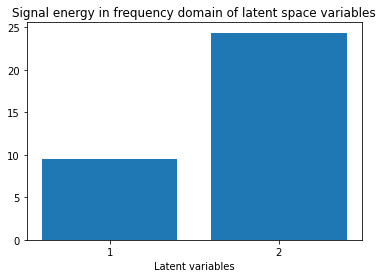

In [12]:
#============================ energy spectrum of signal ==========================
signal_energy = []
for n in range(0,latent_test.shape[1]):
    signal_in = latent_test[:,n]
    signal_fft = np.fft.fft(signal_in)
    signal_energy.append(np.sum(np.abs(signal_fft)**2)/signal_fft.size)

plt.figure()
plt.bar(np.arange(latent_dim)+1,signal_energy)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
plt.title("Signal energy in frequency domain of latent space variables")
plt.show()

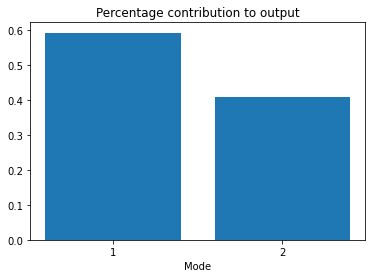

1.0


In [29]:
#============================ mse loss ============================================
per_mode = np.mean(np.sum(modes_test,axis=(2,3,4))/np.sum(y_test,axis=(1,2,3)),axis=1) # contribution per mode, adds up to 1

plt.figure()
plt.bar(np.arange(latent_dim)+1,per_mode*100)
plt.xticks(np.arange(latent_dim)+1)
plt.xlabel("Mode")
plt.title("Percentage contribution to output")
plt.show()

print(np.sum(per_mode)) # test, should be 1.0